# Example of DOV search methods for samples (monsters)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_grondmonsters.ipynb)

## Use cases explained below
* Get samples in a bounding box
* Get samples with specific properties
* Get samples in a bounding box based on specific properties
* Select samples in a municipality and return depth
* Get samples, returning fields not available in the standard output dataframe

In [1]:
%matplotlib inline
import inspect, sys

In [2]:
# check pydov path
import pydov

## Get information about the datatype 'Monster'

In [3]:
from pydov.search.monster import MonsterSearch
monster = MonsterSearch()

A description is provided for the 'Monster' datatype:

In [4]:
print(monster.get_description())

Monsters in DOV zijn monsters die gekoppeld zijn aan een boring. Deze monsters zijn gekenmerkt door een diepte ten opzichte van het maaiveld en door de manier van staalname. De geografische ligging (X en Y (mL72) en Z (mTAW)) nemen ze over van de gekoppelde boring. Aan deze monsters zijn laboproeven, namelijk resultaten afkomstig van analyses in het laboratorium of enkel referenties naar bepaalde analyses, gekoppeld. De analyseresultaten van de monsters kunnen zeer divers zijn, namelijk onderkenningsproeven met centraal de korrelgrootteverdeling maar ook plasticiteitsgrenzen en humus- en kalkgehalte, metingen van volumemassa- en watergehalte en referenties van doorlatendheid, samendrukbaarheid en schuifweerstandkarakteristieken, glauconietgehalte en steenkoolanalyses. De gegevens van de monsters en de laboresultaten kunnen worden geëxporteerd in een rapport.


The different fields that are available for objects of the 'Grondmonster' datatype can be requested with the get_fields() method:

In [5]:
fields = monster.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

id
naam
pkey_monster
gekoppeld_aan
pkey_parents
materiaalklasse
diepte_van_m
diepte_tot_m
observaties
datum_monstername
monstersamenstelling
monstertype
bemonsteringsprocedure
bemonsteringsinstrument
bemonstering_door
opmerkingen
opslaglocatie
opdracht
permkey_monster
geom


You can get more information of a field by requesting it from the fields dictionary:
* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field

In [6]:
fields['materiaalklasse']

{'name': 'materiaalklasse',
 'definition': 'aan te vullen',
 'type': 'string',
 'notnull': False,
 'query': True,
 'cost': 1}

## Example use cases

### Get samples in a bounding box

Get data for all the samples that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [9]:
from pydov.util.location import Within, Box

df = monster.search(location=Within(Box(122000, 187000, 124000, 189000)))
df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,12,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,5.50,6.00,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
1,https://oefen.dov.vlaanderen.be/data/monster/2...,16A,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.00,7.12,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
2,https://oefen.dov.vlaanderen.be/data/monster/2...,16B,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.12,7.27,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
3,https://oefen.dov.vlaanderen.be/data/monster/2...,16C,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.27,7.43,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
4,https://oefen.dov.vlaanderen.be/data/monster/2...,16D,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.43,7.50,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek


The dataframe contains samples. The available data are flattened to represent unique attributes per row of the dataframe.

Using the *pkey_monster* field one can request the details of this sample in a webbrowser:
https://www.dov.vlaanderen.be/data/grondmonster/*pkey_monster*

In [10]:
for pkey_monster in set(df.loc[df.naam == '16C'].pkey_monster):
    print(pkey_monster)

https://oefen.dov.vlaanderen.be/data/monster/2017-180446


### Get samples with specific properties

Next to querying samples based on their geographic location within a bounding box, we can also search for borehole samples matching a specific set of properties. For this we can build a query using a combination of the 'Monster' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [11]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all boreholes that are within the community (gemeente) of 'Wichelen':

In [13]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='bemonsteringsinstrument',
                          literal='steekbus')
df = monster.search(query=query)

df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,1,|https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-01,1.0,1.14,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
1,https://oefen.dov.vlaanderen.be/data/monster/2...,1,|https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-06,1.0,1.16,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
2,https://oefen.dov.vlaanderen.be/data/monster/2...,1,|https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-06,1.0,1.37,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
3,https://oefen.dov.vlaanderen.be/data/monster/2...,1,|https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-04-02,1.0,1.19,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica
4,https://oefen.dov.vlaanderen.be/data/monster/2...,1,|https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1973-10-29,1.0,1.29,ongeroerd,ENKELVOUDIG,NaN,steekbus,Rijksinstituut voor Grondmechanica


Once again we can use the *pkey_monster* as a permanent link to the information of these samples:

In [17]:
for pkey_monster in set(df.loc[df['pkey_parents'].str.contains('boring/1981-016310', na=False), 'pkey_monster']):
    print(pkey_monster)

https://oefen.dov.vlaanderen.be/data/monster/2017-199314
https://oefen.dov.vlaanderen.be/data/monster/2017-199325
https://oefen.dov.vlaanderen.be/data/monster/2017-199322
https://oefen.dov.vlaanderen.be/data/monster/2017-199323
https://oefen.dov.vlaanderen.be/data/monster/2017-199326
https://oefen.dov.vlaanderen.be/data/monster/2017-199315
https://oefen.dov.vlaanderen.be/data/monster/2017-199324
https://oefen.dov.vlaanderen.be/data/monster/2017-199319
https://oefen.dov.vlaanderen.be/data/monster/2017-199320
https://oefen.dov.vlaanderen.be/data/monster/2017-199318
https://oefen.dov.vlaanderen.be/data/monster/2017-199317
https://oefen.dov.vlaanderen.be/data/monster/2017-199313
https://oefen.dov.vlaanderen.be/data/monster/2017-199321


### Get samples in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the samples within a bounding box that have specific properties.

The following example requests the samples with a depth greater than or equal to 15 meters within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [18]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo

query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_tot_m',
            literal='15')

df = monster.search(
    location=Within(Box(122000, 187000, 124000, 189000)),
    query=query
    )

df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,39A,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,17.00,17.37,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
1,https://oefen.dov.vlaanderen.be/data/monster/2...,39B,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,17.37,17.40,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek
2,https://oefen.dov.vlaanderen.be/data/monster/2...,N4A,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2009-05-28,15.75,15.90,ongeroerd,ENKELVOUDIG,22475-1-2007,steekbus,VO - Afdeling Geotechniek
3,https://oefen.dov.vlaanderen.be/data/monster/2...,N4B,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2009-05-28,15.90,16.15,ongeroerd,ENKELVOUDIG,22475-1-2007,steekbus,VO - Afdeling Geotechniek
4,https://oefen.dov.vlaanderen.be/data/monster/2...,N8,|https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2005-01-18,16.50,17.00,ongeroerd,ENKELVOUDIG,NaN,steekbus,MVG - Afdeling Geotechniek


### Get sample based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select samples as illustrated below.

For example, make a selection of the boreholes in municipality the of Antwerp, for which a hydrogeological interpretation was performed:

In [ ]:
from owslib.fes2 import And

query = And([PropertyIsEqualTo(propertyname='materiaalklasse',
                               literal='Antwerpen'),
             PropertyIsEqualTo(propertyname='hydrogeologische_stratigrafie', 
                               literal='True')]
            )
df = monster.search(query=query,
                   return_fields=('pkey_boring', 'boornummer', 'x', 'y', 'diepte_boring_tot', 'datum_aanvang'))
df.head()

### Get a boxplot with the depth distribution of samples with sampling instrument 'steekbuis'

In [21]:
query = PropertyIsEqualTo(propertyname='bemonsteringsinstrument',
                          literal='steekbus')
df = monster.search(query=query)


[000/001] .


In [22]:
df.describe()

,diepte_van_m,diepte_tot_m
count,31569.000000,31591.000000
mean,6.755560,7.085249
std,7.109394,7.148988
min,0.000000,0.100000
25%,2.000000,2.290000
50%,4.400000,4.650000
75%,9.000000,9.220000
max,60.000000,60.300000


Text(0.5, 1.0, "Depth distribution samples with sampling instrument 'steekbus'")

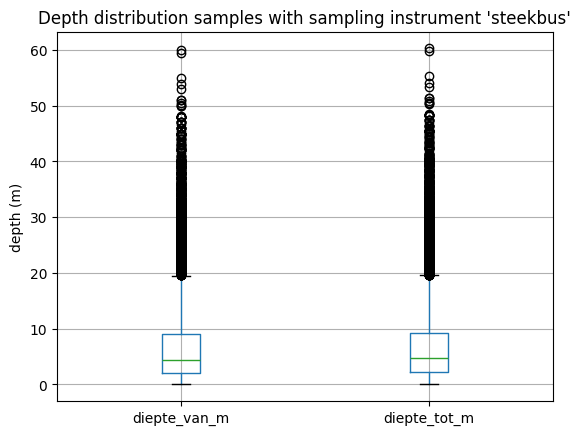

In [23]:
ax = df[df.diepte_tot_m != 0].boxplot()
ax.set_ylabel("depth (m)")
ax.set_title("Depth distribution samples with sampling instrument 'steekbus'")

## Get samples, returning fields not available in the standard output dataframe NOG AAN TE PASSEN

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select borehole samples as illustrated below.

For example, make a selection of the borehole samples in the municipality of Antwerp, for which a mechanical test was carried out

In [16]:
from owslib.fes2 import And

query = And([PropertyIsEqualTo(propertyname='gemeente',
                               literal='Antwerpen'),
             PropertyIsEqualTo(propertyname='mechanisch', 
                               literal='True')]
            )
df = grondmonster.search(query=query,
                   return_fields=('pkey_grondmonster', 'boornummer', 'x', 'y'))
df.head()

[000/001] .


,pkey_grondmonster,boornummer,x,y
0,https://www.dov.vlaanderen.be/data/grondmonste...,GEO-14/029-B5,145459.26,221075.09
1,https://www.dov.vlaanderen.be/data/grondmonste...,GEO-14/029-B5,145459.26,221075.09
2,https://www.dov.vlaanderen.be/data/grondmonste...,GEO-14/029-B56,147046.11,219486.68
3,https://www.dov.vlaanderen.be/data/grondmonste...,GEO-14/029-B56,147046.11,219486.68
4,https://www.dov.vlaanderen.be/data/grondmonste...,GEO-14/029-B56,147046.11,219486.68


The data from the mechanical tests are not always available through the webservice. Following the URI of the borehole sample, one can access the available information in the subtype 'mechanisch'.

In [17]:
for pkey_grondmonster in set(df.loc[df.boornummer=='1445-GEO-17/047-B211'].pkey_grondmonster):
    print(pkey_grondmonster)

https://www.dov.vlaanderen.be/data/grondmonster/2018-211727
https://www.dov.vlaanderen.be/data/grondmonster/2018-211729
https://www.dov.vlaanderen.be/data/grondmonster/2018-211656
https://www.dov.vlaanderen.be/data/grondmonster/2018-211728


## Visualize results NOG AAN TE PASSEN

Using Folium, we can display the results of our search on a map.

In [24]:
# import the necessary modules (not included in the requirements of pydov!)
import folium
from folium.plugins import MarkerCluster
from pyproj import Transformer

In [25]:
# convert the coordinates to lat/lon for folium
def convert_latlon(x1, y1):
    transformer = Transformer.from_crs("epsg:31370", "epsg:4326", always_xy=True)
    x2,y2 = transformer.transform(x1, y1)
    return x2, y2

df['lon'], df['lat'] = zip(*map(convert_latlon, df['x'], df['y'])) 
# convert to list
loclist = df[['lat', 'lon']].values.tolist()

KeyError: 'x'

In [20]:
# initialize the Folium map on the centre of the selected locations, play with the zoom until ok
fmap = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)
marker_cluster = MarkerCluster().add_to(fmap)
for loc in range(0, len(loclist)):
    folium.Marker(loclist[loc], popup=df['boornummer'][loc]).add_to(marker_cluster)
fmap
